# Image Forgery Localization

**Problem Statement**

    Detection and Localization of Forgeries in Digital Images.
    
**Reference** 

    This is an implementation of the  https://vcg.engr.ucr.edu/sites/g/files/rcwecm2661/files/2019-02/iccv_jawad.pdf 
    Research paper.
    
**Steps**

    1) According to this paper, Split the images and Corresponding Image Masks into Non Over-Lapping patches.
    
    2) Feed the image patch and it's corresponding mask patch to the model they had used.
    
    3) The Model Outputs two Output: One for the The patch Classification(If a patch is modified or not). And the corresponding Image Patch.
    
    **In this paper they have used a Single model for predicting both patch classification and Mask generation,
    However I split it into 2 because of memory constrains.**
    
**Dataset**

    This is a synthetic dataset generated. This dataset is generated by splicing different objects obtained from MS-COCO dataset into the images of DRESDEN benchmark.
    
    Download from https://www.dropbox.com/sh/palus3sq4zvdky0/AACu3s7KA5Fhr_BJUeDOxnTLa?dl=0
    
    The Dataset is the Same the authors have used for the implementation of their paper.
    
    For the implementation I used two Datasets :
    
    Spliced_nist : Pristine images from the MFC18, spliced with a single object from the MS_COCO dataset
    
    Copymove_nist : Pristine images from the MFC18, with a single object from MS_COCO spliced onto it multiple times 

    Both Datasets Contain around 54k images 27k in each. However I have considered only 4K images 2 k from both for training the patch prediction classifier and 2k(1k from each) for patch generation because of memory issues. 


# Part 1 : Patch Classification 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#Download Splicing Dataset
import urllib.request
import urllib
urllib.request.urlretrieve('https://uc7e4a195b875e123ea00d89695d.dl.dropboxusercontent.com/cd/0/get/Aruw4BxftEN9qaBYAFtYj0e_OhfsAaPDBDsjxGA1LYE-zTQyK-22U-DtTbaZajae7zR2ihSDP9pkHJWltE4LPAJOBLyi9dWkPo7L5x9365eyQg/file?_download_id=37220631358513545378435358317117461844463738764358593021804845604&_notify_domain=www.dropbox.com&dl=1', 'spliced_nist.zip')

('spliced_nist.zip', <http.client.HTTPMessage at 0x7ff998d19978>)

In [0]:
#Extract the Files
from zipfile import ZipFile

with ZipFile('spliced_nist.zip', 'r') as zip: 
  # printing all the contents of the zip file 
  #zip.printdir() 
  
  # extracting all the files 
  print('Extracting all the files now...') 
  zip.extractall() 
  print('Done!') 

Extracting all the files now...
Done!


In [0]:
#Download Copymove Dataset
import urllib.request
import urllib
urllib.request.urlretrieve('https://uc71dd294b8827af63ac0b070af4.dl.dropboxusercontent.com/cd/0/get/Artp1pI8JOLaLCb-LTJZxtgfHPi9ZFvujlEx1_0PQfcIrkq5Y2cX90sOFGz-GRHnGaS0bhjOuUK5mE1EgVjOAYtaMlKWjL16yZjlMOMLmtsOIw/file?_download_id=34921538410429416882755380695285425544943328007029222089171242693&_notify_domain=www.dropbox.com&dl=1', 'copymove_nist.zip')

('copymove_nist.zip', <http.client.HTTPMessage at 0x7ff9976bc198>)

In [0]:
#Extract The Copy Move Dataset
from zipfile import ZipFile

with ZipFile('copymove_nist.zip', 'r') as zip: 
  # printing all the contents of the zip file 
  #zip.printdir() 
  
  # extracting all the files 
  print('Extracting all the files now...') 
  zip.extractall() 
  print('Done!') 

Extracting all the files now...
Done!


In [0]:
#Take 2000 files from the Splice Dataset

from tqdm import tqdm
import os
import cv2
from cv2 import imread
from sklearn.feature_extraction import image
img_arr = []
mask_arr = []

files = sorted(os.listdir('/content/Bernard/Computer_Vision/spliced_NIST/rgb_imgs'))


for i in files[:2000]:
  #cv2.IMREAD_GRAYSCALE
  img = imread('/content/Bernard/Computer_Vision/spliced_NIST/rgb_imgs/'+i)
  img = cv2.resize(img,(256,256))
  
  img_arr.append(img)
  #cv2.IMREAD_GRAYSCALE
  
  mask = imread('/content/Bernard/Computer_Vision/spliced_NIST/masks/'+i.split('_rgb.png')[0]+'_mask.png')
  mask = cv2.resize(mask,(256,256))
  mask_arr.append(mask)

In [0]:
#Take 2000 files from Copymove Dataset.

files = sorted(os.listdir('/content/Bernard/Computer_Vision/spliced_copymove_NIST/rgb_imgs'))
    
for i in files[:2000]:
  #cv2.IMREAD_GRAYSCALE
  img = imread('/content/Bernard/Computer_Vision/spliced_copymove_NIST/rgb_imgs/'+i)
  img = cv2.resize(img,(256,256))
  
  img_arr.append(img)
  #cv2.IMREAD_GRAYSCALE
  
  mask = imread('/content/Bernard/Computer_Vision/spliced_copymove_NIST/masks/'+i.split('_rgb.png')[0]+'_mask.png')
  mask = cv2.resize(mask,(256,256))
  mask_arr.append(mask)

Populating the interactive namespace from numpy and matplotlib


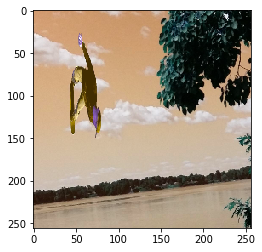

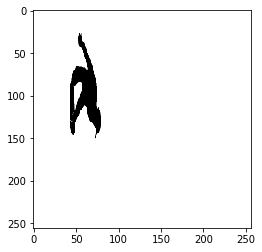

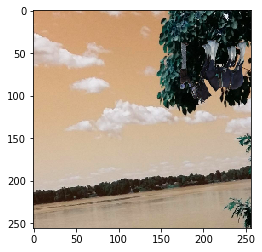

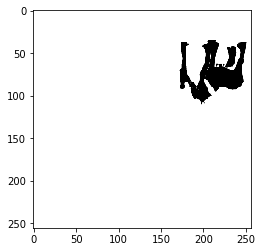

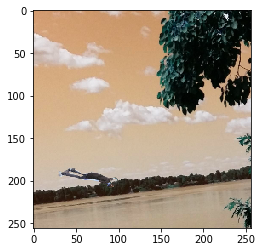

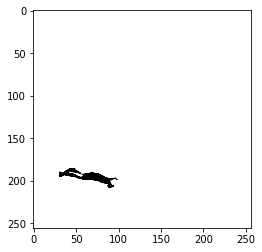

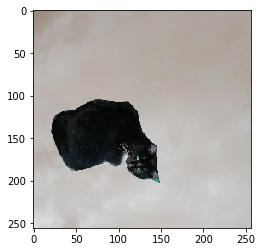

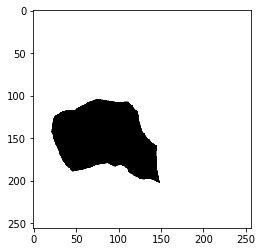

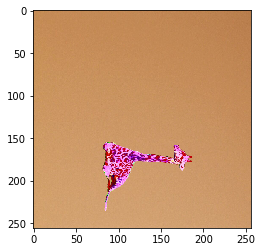

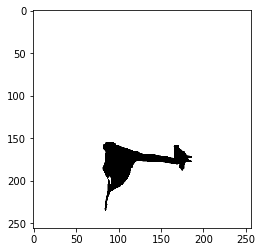

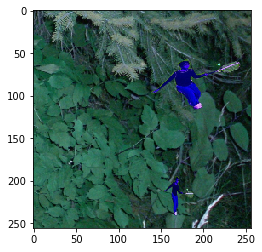

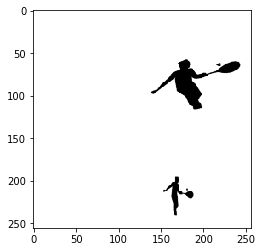

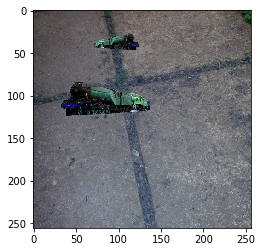

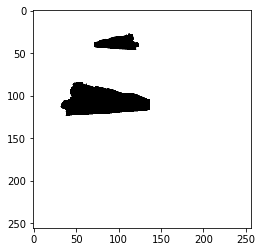

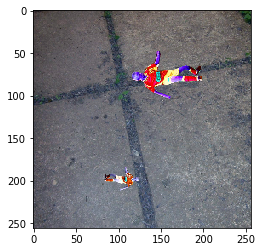

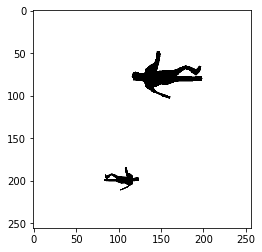

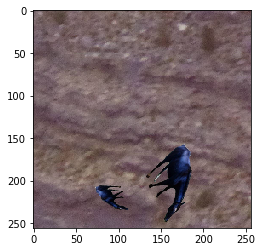

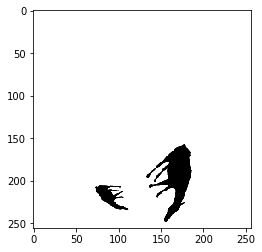

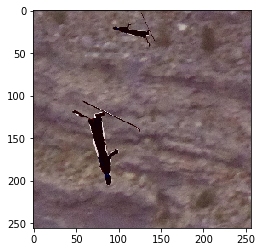

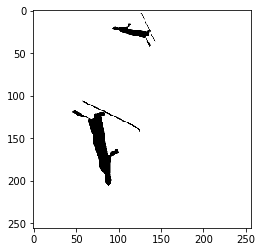

In [0]:
#Display Some Random Samples.
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in range(1995,2005):
  imgplot = plt.imshow(img_arr[i])
  plt.show()
  maskplot = plt.imshow(mask_arr[i])
  plt.show()

In [0]:
#https://stackoverflow.com/questions/49338166/python-intersection-over-union
#According to the paper any patch with IOU>12.5 is modified patch and others as pristine
#Function takes two patches and returns if it's modified or not.
def get_patch_labels(mask_im,img_im):
  overlap = mask_im*img_im # Logical AND
  union = mask_im + img_im # Logical OR
  IOU = overlap.sum()/float(union.sum())
  if(IOU<=0.875):
    return 1 #Patch modified
  else:
    return 0 #Patch is unmodified(True)                          

In [0]:
#Split Images and corresponding masks into 64 patches of size 32x32.
#https://github.com/jawadbappy/forgery_localization_HLED/blob/master/Radon/extract_resamp_feat.py
#Same as what the authors have used
from skimage.util import view_as_windows
from tqdm import tqdm

patch_arr = [] #Store all Patches of Images.
patch_label = [] #Store labels of patches 0 = unmodified, 1= modified.
patch_mask = [] #Store all the masks.

for i in tqdm(range(4000)):
  
  img_patches = view_as_windows(img_arr[i],(32,32,3),32)
  img_patches = np.squeeze(img_patches)
  img_patches = np.reshape(img_patches,(64,32,32,3))
  
  mask_patches = view_as_windows(np.round(mask_arr[i]/255),(32,32,3),32)
  mask_patches = np.squeeze(mask_patches)
  mask_patches = np.reshape(mask_patches,(64,32,32,3))
  
  for k in range(len(mask_patches)):
    patch_arr.append(img_patches[k])
    patch_label.append((get_patch_labels(mask_patches[k],img_patches[k])))
    patch_mask.append(mask_patches[k])

100%|██████████| 4000/4000 [00:17<00:00, 226.09it/s]


In [0]:
import pandas as pd
df = pd.DataFrame(columns=['Patch','Mask','Label'])
df['Patch'] = patch_arr
df['Mask'] = patch_mask
df['Label'] = patch_label
df.head()

Patch  ... Label
0  [[[108, 108, 108], [104, 104, 104], [115, 115,...  ...     0
1  [[[81, 81, 81], [71, 71, 71], [54, 54, 54], [4...  ...     0
2  [[[51, 51, 51], [54, 54, 54], [56, 56, 56], [7...  ...     0
3  [[[37, 37, 37], [38, 38, 38], [38, 38, 38], [3...  ...     0
4  [[[106, 106, 106], [85, 85, 85], [109, 109, 10...  ...     0

[5 rows x 3 columns]

In [0]:
df['Label'].value_counts()

0    224510
1     31490
Name: Label, dtype: int64

- > Data is imbalanced, So Care must be taken to avoid Overfitting

In [0]:
import numpy as np
img_rows, img_cols = 32, 32
x_train = np.array(patch_arr).reshape(len(patch_arr), img_rows, img_cols,3)

x_train = x_train.astype('float32')
x_train /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
input_shape = (img_rows, img_cols, 3)

x_train shape: (256000, 32, 32, 3)
256000 train samples


In [0]:
from keras.utils import to_categorical
y_train = to_categorical(patch_label)

Using TensorFlow backend.


In [0]:
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten,Reshape,Concatenate,Add,LSTM,Lambda,ConvLSTM2D,Flatten,UpSampling3D,GlobalAveragePooling2D,Conv2DTranspose,BatchNormalization
from keras.layers.core import Dense, Dropout

input_img = Input(shape=(32,32,3),name='patch_input')
x = Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
x = Conv2D(1, (5, 5), activation='relu', padding='same')(x)
x = Reshape(target_shape=(32,32))(x)
x.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32)])

In [0]:
#Three LSTM Cells
lstm_1 = LSTM(32,return_sequences=True,activation='relu')(x)
lstm_2 = LSTM(32,return_sequences=True,activation='relu')(lstm_1)
lstm_3 = LSTM(32,return_sequences=True,activation='relu')(lstm_2)

In [0]:
import tensorflow as tf
#Function to Stack the 3 LSTM Cells
def stack_layers(arr):
   return(tf.keras.backend.stack([arr[0],arr[1],arr[2]],axis=3))

In [0]:
stack_lstm = Lambda(stack_layers)([lstm_1,lstm_2,lstm_3])
stack_lstm.shape

TensorShape([Dimension(None), Dimension(None), Dimension(32), Dimension(3)])

In [0]:
flat = Flatten()(stack_lstm)
flat = Dense(2048,activation='relu')(flat)
flat = Dropout(0.5)(flat)
flat = Dense(1024,activation='relu')(flat)
flat = Dropout(0.5)(flat)

flat = Dense(512,activation='relu')(flat)
#flat = Dropout(0.25)(flat)
flat = Dense(256,activation='relu')(flat)
#flat = Dropout(0.15)(flat)

flat = Dense(128,activation='relu')(flat)

#flat = Dense(2,activation='relu')(flat)

out_1 = Dense(2,activation='softmax')(flat)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#Calculate the F1 Score
#Macro F1 calculation https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [0]:
model = Model(inputs = [input_img], outputs=[out_1])
model.compile(optimizer='Adam', loss=['categorical_crossentropy'],metrics=[f1])
model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
patch_input (InputLayer)        (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   1216        patch_input[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 1)    401         conv2d_1[0][0]                   
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 32, 32)       0           conv2d_2[0][0]                

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_f1', min_delta=0, patience=25, verbose=0, mode='max', baseline=None, restore_best_weights=True)
history = model.fit(x_train,y_train,batch_size=1024,epochs=300,validation_data = (x_train,y_train),verbose=1,
                    callbacks=[es],shuffle=False) 




Train on 256000 samples, validate on 256000 samples
Epoch 1/300





256000/256000 [==============================] - 114s 445us/step - loss: 0.3047 - f1: 0.4941 - val_loss: 0.2773 - val_f1: 0.6871
Epoch 2/300
256000/256000 [==============================] - 102s 398us/step - loss: 0.2566 - f1: 0.5922 - val_loss: 0.2392 - val_f1: 0.7150
Epoch 3/300
256000/256000 [==============================] - 102s 399us/step - loss: 0.2413 - f1: 0.6367 - val_loss: 0.2296 - val_f1: 0.7191
Epoch 4/300
256000/256000 [==============================] - 102s 397us/step - loss: 0.2338 - f1: 0.6691 - val_loss: 0.2218 - val_f1: 0.7309
Epoch 5/300
256000/256000 [==============================] - 102s 397us/step - loss: 0.2391 - f1: 0.6696 - val_loss: 0.2289 - val_f1: 0.7374
Epoch 6/300
256000/256000 [==============================] - 102s 397us/step - loss: 0.2392 - f1: 0.6733 - val_loss: 0.2223 - val_f1: 0.7499
Epoch 7/300
256000/256000 [==============================] - 102s 397us/step - loss: 0.2213 - 

In [0]:
#Save The Model
model.save("/content/drive/My Drive/retrain_new.h5")

In [0]:
#Evaluate the model on train set
print("Train f1 Score = ",model.evaluate(x_train,y_train,batch_size=1024,verbose=1))

256000/256000 [==============================] - 26s 102us/step
Train f1 Score =  [0.0012677200326288586, 0.9994883377552033]


In [0]:
out = model.predict(x_train)

In [0]:
#Get the true and predicted Labels.
true_labels = []
for i in y_train:
  true_labels.append(np.argmax(i))

pred_labels = []
for i in out:
  pred_labels.append(np.argmax(i))

In [0]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    224510
           1       1.00      1.00      1.00     31490

    accuracy                           1.00    256000
   macro avg       1.00      1.00      1.00    256000
weighted avg       1.00      1.00      1.00    256000



In [0]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(true_labels,pred_labels)

array([[224499,     11],
       [    44,  31446]])

**Testing with Some other points in Synthetic Dataset**

- > Test the model with 2000 images(1k images from both the Data set). And evaluate the performance of the above model.

In [0]:
#Load from Splice Dataset
files = sorted(os.listdir('/content/Bernard/Computer_Vision/spliced_NIST/rgb_imgs'))


img_arr = []
mask_arr = []

for i in files[2000:3000]:
  #cv2.IMREAD_GRAYSCALE
  img = imread('/content/Bernard/Computer_Vision/spliced_NIST/rgb_imgs/'+i)
  img = cv2.resize(img,(256,256))
  
  img_arr.append(img)
  #cv2.IMREAD_GRAYSCALE
  
  mask = imread('/content/Bernard/Computer_Vision/spliced_NIST/masks/'+i.split('_rgb.png')[0]+'_mask.png')
  mask = cv2.resize(mask,(256,256))
  mask_arr.append(mask)

In [0]:
#Load from Copy Move Dataset.
files = sorted(os.listdir('/content/Bernard/Computer_Vision/spliced_copymove_NIST/rgb_imgs'))

    
for i in files[2000:3000]:
  #cv2.IMREAD_GRAYSCALE
  img = imread('/content/Bernard/Computer_Vision/spliced_copymove_NIST/rgb_imgs/'+i)
  img = cv2.resize(img,(256,256))
  
  img_arr.append(img)
  #cv2.IMREAD_GRAYSCALE
  
  mask = imread('/content/Bernard/Computer_Vision/spliced_copymove_NIST/masks/'+i.split('_rgb.png')[0]+'_mask.png')
  mask = cv2.resize(mask,(256,256))
  mask_arr.append(mask)

In [0]:
#Get Patches of Test Set.
from skimage.util import view_as_windows
from tqdm import tqdm

patch_arr = []
patch_label = []
patch_mask = []

for i in tqdm(range(2000)):
  
  #img_patches = image.extract_patches_2d(img_arr[i], (96, 96),random_state=24)
  img_patches = view_as_windows(img_arr[i],(32,32,3),32)
  img_patches = np.squeeze(img_patches)
  img_patches = np.reshape(img_patches,(64,32,32,3))
  
  mask_patches = view_as_windows(np.round(mask_arr[i]/255),(32,32,3),32)
  mask_patches = np.squeeze(mask_patches)
  mask_patches = np.reshape(mask_patches,(64,32,32,3))
  
  for k in range(len(mask_patches)):
    patch_arr.append(img_patches[k])
    patch_label.append((get_patch_labels(mask_patches[k],img_patches[k])))
    patch_mask.append(mask_patches[k])

100%|██████████| 2000/2000 [00:09<00:00, 212.90it/s]


In [0]:
import numpy as np
img_rows, img_cols = 32, 32
x_test = np.array(patch_arr).reshape(len(patch_arr), img_rows, img_cols,3)

x_test = x_test.astype('float32')
x_test /= 255
print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'train samples')
input_shape = (img_rows, img_cols, 3)

x_test shape: (128000, 32, 32, 3)
128000 train samples


In [0]:
from keras.utils import to_categorical
y_test = to_categorical(patch_label)

In [0]:
print("Test f1 Score = ",model.evaluate(x_test,y_test,batch_size=1024,verbose=1))

128000/128000 [==============================] - 14s 107us/step
Test f1 Score =  [0.6278297927379608, 0.7560260372161866]


In [0]:
out = model.predict(x_test)

In [0]:
true_labels = []
for i in y_train:
  true_labels.append(np.argmax(i))

pred_labels = []
for i in out:
  pred_labels.append(np.argmax(i))

In [0]:
#Classification Report of Test Set
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93    112510
           1       0.49      0.74      0.59     15490

    accuracy                           0.87    128000
   macro avg       0.72      0.82      0.76    128000
weighted avg       0.90      0.87      0.88    128000



In [0]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(true_labels,pred_labels)

array([[100302,  12208],
       [  3973,  11517]])

**Test Using the IEEE Dataset**

Testing the model using the IEEE Dataset.

- > Here I used a different approach which was not mentioned in the original paper. Instead of predicting the patch classification, I will take the image and predict if it's fake or true. Since only patch classification is present in the Training, I will use a different approach wherein I will take an image and it's patches predict the patch classification using the following: if majority of the patches are predicted as Fake => Image is Fake else image is Pristing. And then Evaluate the Model.

In [0]:
import urllib.request
import urllib
urllib.request.urlretrieve('https://uc7e422c3a15df07106e61ec1239.dl.dropboxusercontent.com/cd/0/get/ArvTDizqlOCDpVTsK0Ia-7tEwhUzCaoVlcTSOOEUSRloyPBVHJE-UoXbZzk_NGHcOUoEN7fz5PaR8AANloQZnNiYk73y8XRsr0Dz4X8Snbv-Ig/file?_download_id=01621319748662486420067062717375284422178191792107252767685770933872&_notify_domain=www.dropbox.com&dl=1', 'phase-01-training.tar.gz')

('phase-01-training.tar.gz', <http.client.HTTPMessage at 0x7ff8dfa3ea90>)

In [0]:
import tarfile
tarf = tarfile.open("phase-01-training.tar.gz")
tarf.extractall()

In [0]:
from tqdm import tqdm
import os
import cv2
from cv2 import imread
from sklearn.feature_extraction import image
#load Pristine Images
img_arr = []
file_names = []
file_names = set()
files = sorted(os.listdir('/content/dataset-dist/phase-01/training/pristine'))

for i in range(len(files)):
  if(files[i].endswith('.png')):
    file_names.add(files[i].split('.')[0])

for i in file_names:
  img = imread('/content/dataset-dist/phase-01/training/pristine/'+str(i)+'.png')
  img = cv2.resize(img,(256,256))
  img_arr.append(img)


In [0]:
#Load Fake images
file_names = set()
files = sorted(os.listdir('/content/dataset-dist/phase-01/training/fake'))

for i in range(len(files)):
  if(files[i].endswith('.png')):
    file_names.add(files[i].split('.')[0])

for i in file_names:
  #cv2.IMREAD_GRAYSCALE
  img = imread('/content/dataset-dist/phase-01/training/fake/'+str(i)+'.png')
  img = cv2.resize(img,(256,256))
  img_arr.append(img)

In [0]:
# Get labels for the whole image 0 = Pristine, 1 = Fake
labels = []
for i in range(len(img_arr)):
  if(i<1050):
    labels.append(0)
  else:
    labels.append(1)

**Divide Images to patches**

In [0]:
from skimage.util import view_as_windows
from tqdm import tqdm

patch_arr = []

for i in tqdm(range(1500)):
  
  #img_patches = image.extract_patches_2d(img_arr[i], (96, 96),random_state=24)
  img_patches = view_as_windows(img_arr[i],(32,32,3),32)
  img_patches = np.squeeze(img_patches)
  img_patches = np.reshape(img_patches,(64,32,32,3))
  
  for k in range(len(img_patches)):
    patch_arr.append(img_patches[k])

100%|██████████| 1500/1500 [00:00<00:00, 3803.73it/s]


In [0]:
#Generate Test Set
import numpy as np
img_rows, img_cols = 32, 32
x_test = np.array(patch_arr).reshape(len(patch_arr), img_rows, img_cols,3)

x_test = x_test.astype('float32')
x_train /= 255
print('x_train shape:', x_test.shape)
print(x_test.shape[0], 'train samples')
input_shape = (img_rows, img_cols, 3)

x_train shape: (96000, 32, 32, 3)
96000 train samples


In [0]:
#Predict for patches.
out_patches = model.predict(x_test)

In [0]:
pred_labels = []
for i in out_patches:
  pred_labels.append(np.argmax(i))

In [0]:
final_label = []
for i in range(len(xx)):
  if(np.count_nonzero(xx[i])<32):
    final_label.append(0) #Image not tampered
  else:
    final_label.append(1) .  #Image Tampered


In [0]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(labels, final_label))

              precision    recall  f1-score   support

           0       0.68      0.29      0.41      1050
           1       0.29      0.68      0.41       450

    accuracy                           0.41      1500
   macro avg       0.49      0.49      0.41      1500
weighted avg       0.57      0.41      0.41      1500



In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels,final_label)

array([[309, 741],
       [143, 307]])

**Patch-Wise Prediction**

In [0]:
from tqdm import tqdm
import os
import cv2
from cv2 import imread
from sklearn.feature_extraction import image
img_arr = []
mask_arr = []
file_names = set()

files = sorted(os.listdir('/content/dataset-dist/phase-01/training/fake'))

for i in range(len(files)):
  if(files[i].endswith('.png')):
    file_names.add(files[i].split('.')[0])
    
for i in file_names:
  #cv2.IMREAD_GRAYSCALE
  img = imread('/content/dataset-dist/phase-01/training/fake/'+str(i)+'.png')
  img = cv2.resize(img,(256,256))
  img_arr.append(img)
  #cv2.IMREAD_GRAYSCALE
  mask = imread('/content/dataset-dist/phase-01/training/fake/'+str(i)+'.mask.png')
  mask = cv2.resize(mask,(256,256))
  mask_arr.append(mask)

In [0]:
from skimage.util import view_as_windows
from tqdm import tqdm

patch_arr = []
patch_label = []
patch_mask = []

for i in tqdm(range(450)):
  
  #img_patches = image.extract_patches_2d(img_arr[i], (96, 96),random_state=24)
  img_patches = view_as_windows(img_arr[i],(32,32,3),32)
  img_patches = np.squeeze(img_patches)
  img_patches = np.reshape(img_patches,(64,32,32,3))
  
  mask_patches = view_as_windows(np.round(mask_arr[i]/255),(32,32,3),32)
  mask_patches = np.squeeze(mask_patches)
  mask_patches = np.reshape(mask_patches,(64,32,32,3))
  
  for k in range(len(mask_patches)):
    patch_arr.append(img_patches[k])
    patch_label.append((get_patch_labels(mask_patches[k],img_patches[k])))
    #patch_mask.append(mask_patches[k])

100%|██████████| 450/450 [00:01<00:00, 263.12it/s]


In [0]:
import numpy as np
img_rows, img_cols = 32, 32
x_test = np.array(patch_arr).reshape(len(patch_arr), img_rows, img_cols,3)

x_test = x_test.astype('float32')
x_test /= 255
print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'train samples')
input_shape = (img_rows, img_cols, 3)

x_test shape: (28800, 32, 32, 3)
28800 train samples


In [0]:
from keras.utils import to_categorical
y_test = to_categorical(patch_label)

In [0]:
print("Test f1 Score = ",model.evaluate(x_test,y_test,batch_size=1024,verbose=1))

28800/28800 [==============================] - 3s 108us/step
Test f1 Score =  [1.8727750184800889, 0.4827634366353353]


In [0]:
out = model.predict(x_test)

In [0]:
true_labels = []
for i in y_test:
  true_labels.append(np.argmax(i))

pred_labels = []
for i in out:
  pred_labels.append(np.argmax(i))

In [0]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.74      0.81     25449
           1       0.12      0.26      0.16      3351

    accuracy                           0.69     28800
   macro avg       0.50      0.50      0.48     28800
weighted avg       0.79      0.69      0.73     28800



In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_labels,pred_labels)

array([[18889,  6560],
       [ 2480,   871]])

In [0]:
from sklearn.metrics import roc_auc_score
roc_auc_score(true_labels, pred_labels)

0.5010759841870269

# Part2: Mask Generation

 - > Here we Localize the Tampering by generating the patches for the Tampered Image.
 
 - > Because of Memory Constraints, I have used only 2000 images for training.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#Download Splicing Dataset
import urllib.request
import urllib
urllib.request.urlretrieve('https://ucf49b15aa1a04f207aba1d0a563.dl.dropboxusercontent.com/cd/0/get/AsKskroQbbIo24uxFf6vPcToIfHbBdzJ_eyJb47klYjRhfmriIDpXHxGV7nVeF4ue-Ls4ejPBIwaFI_KpKITGd6sdo1w0Mimx9ypcwXDLiRH1w/file?_download_id=78290939925937949489499076779349182709107300488289991144109189909&_notify_domain=www.dropbox.com&dl=1', 'spliced_nist.zip')

('spliced_nist.zip', <http.client.HTTPMessage at 0x7f958bdc75f8>)

In [0]:
#Extract Splicing Dataset
from zipfile import ZipFile

with ZipFile('spliced_nist.zip', 'r') as zip: 
  # printing all the contents of the zip file 
  #zip.printdir() 
  
  # extracting all the files 
  print('Extracting all the files now...') 
  zip.extractall() 
  print('Done!') 

Extracting all the files now...
Done!


In [0]:
#Download Copymove Dataset
import urllib.request
import urllib
urllib.request.urlretrieve('https://uc3199594bcf34810ba5c374eec6.dl.dropboxusercontent.com/cd/0/get/AsKO2KS_P58uHCzS4QbzZNy1Elhg2SuAwfg4TQGASSbVyfUkbzlfPIQF4efMe4usx0fqq9bscUHFv_nT1lfFIWi5MR8FJZGqFKFTA1eIuAXDSQ/file?_download_id=460498100197354042122598020383097455103883829244787843622507314367&_notify_domain=www.dropbox.com&dl=1', 'copymove_nist.zip')

('copymove_nist.zip', <http.client.HTTPMessage at 0x7f950c03ff98>)

In [0]:
#Extract Copymove Dataset.
from zipfile import ZipFile

with ZipFile('copymove_nist.zip', 'r') as zip: 
  # printing all the contents of the zip file 
  #zip.printdir() 
  
  # extracting all the files 
  print('Extracting all the files now...') 
  zip.extractall() 
  print('Done!') 

Extracting all the files now...
Done!


In [0]:
import urllib.request
import urllib
urllib.request.urlretrieve('https://ucc4e99a3085683742100b8a8799.dl.dropboxusercontent.com/cd/0/get/AsKPkkCrAISYZKhj2ua-kUWWlKYmYr3lMZbrZGw0UaESAPCZZtRVTyfNkeQ-fzpCrKX_ufelKifa1OZjJ0hiX9sVeP7NfKSpIDNUPjm5hJiQAQ/file?_download_id=57697320011109199313716808275054460033420528170404226119140266693&_notify_domain=www.dropbox.com&dl=1', 'phase-01-training.tar.gz')

('phase-01-training.tar.gz', <http.client.HTTPMessage at 0x7f9589e70898>)

In [0]:
import tarfile
tarf = tarfile.open("phase-01-training.tar.gz")
tarf.extractall()

In [0]:
#Take 1000 files from Splice dataset and 1000 from Copymove Dataset.

from tqdm import tqdm
import os
import cv2
from cv2 import imread
from sklearn.feature_extraction import image
img_arr = []
mask_arr = []

files = sorted(os.listdir('/content/Bernard/Computer_Vision/spliced_NIST/rgb_imgs'))

#for i in range(len(files)):
#  if(files[i].endswith('.png')):
#    file_names.add(files[i].split('.')[0])
    
for i in files[:1000]:
  #cv2.IMREAD_GRAYSCALE
  img = imread('/content/Bernard/Computer_Vision/spliced_NIST/rgb_imgs/'+i)
  img = cv2.resize(img,(256,256))
  
  img_arr.append(img)
  #cv2.IMREAD_GRAYSCALE
  
  mask = imread('/content/Bernard/Computer_Vision/spliced_NIST/masks/'+i.split('_rgb.png')[0]+'_mask.png')
  mask = cv2.resize(mask,(256,256))
  mask_arr.append(mask)

In [0]:
#Load Copy Move Dataset

files = sorted(os.listdir('/content/Bernard/Computer_Vision/spliced_copymove_NIST/rgb_imgs'))


for i in files[:1000]:
  #cv2.IMREAD_GRAYSCALE
  img = imread('/content/Bernard/Computer_Vision/spliced_copymove_NIST/rgb_imgs/'+i)
  img = cv2.resize(img,(256,256))
  
  img_arr.append(img)
  #cv2.IMREAD_GRAYSCALE
  
  mask = imread('/content/Bernard/Computer_Vision/spliced_copymove_NIST/masks/'+i.split('_rgb.png')[0]+'_mask.png')
  mask = cv2.resize(mask,(256,256))
  mask_arr.append(mask)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


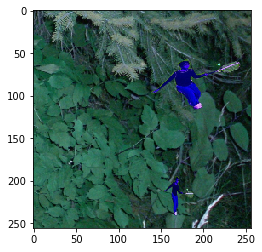

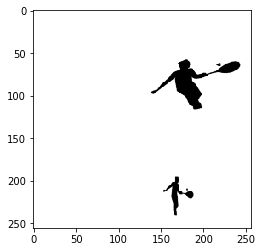

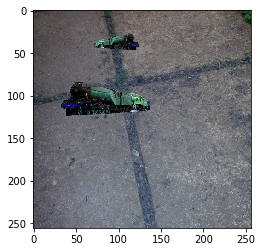

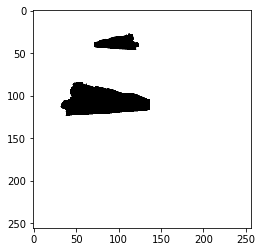

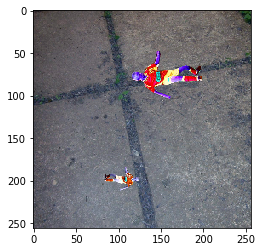

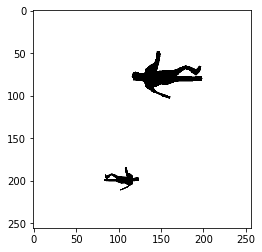

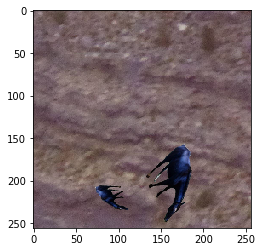

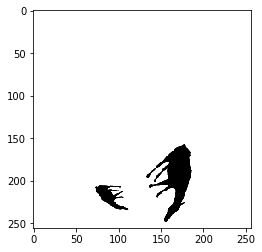

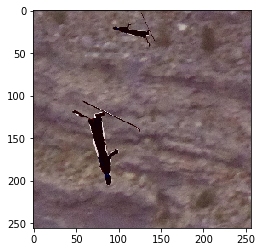

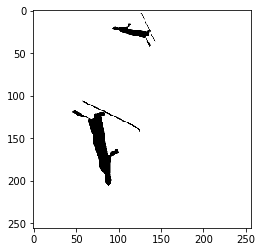

In [0]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in range(1000,1005):
  imgplot = plt.imshow(img_arr[i])
  plt.show()
  maskplot = plt.imshow(mask_arr[i])
  plt.show()

In [0]:
#Generate patches for both Images and Masks.
from skimage.util import view_as_windows
from tqdm import tqdm

patch_arr = []
patch_label = []
patch_mask = []

for i in tqdm(range(2000)):
  
  #img_patches = image.extract_patches_2d(img_arr[i], (96, 96),random_state=24)
  img_patches = view_as_windows(img_arr[i],(32,32,3),32)
  img_patches = np.squeeze(img_patches)
  img_patches = np.reshape(img_patches,(64,32,32,3))
  
  mask_patches = view_as_windows(np.round(mask_arr[i]/255),(32,32,3),32)
  mask_patches = np.squeeze(mask_patches)
  mask_patches = np.reshape(mask_patches,(64,32,32,3))

  for k in range(len(mask_patches)):
    patch_arr.append(img_patches[k])
    patch_mask.append(mask_patches[k])

100%|██████████| 2000/2000 [00:07<00:00, 265.89it/s]


In [0]:
import numpy as np
img_rows, img_cols = 32, 32
x_train = np.array(patch_arr).reshape(len(patch_arr), img_rows, img_cols,3)

x_train = x_train.astype('float32')
x_train /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
input_shape = (img_rows, img_cols, 3)

x_train shape: (128000, 32, 32, 3)
128000 train samples


In [0]:
import numpy as np
img_rows, img_cols = 32, 32
y_train = np.array(patch_mask).reshape(len(patch_mask), img_rows, img_cols,3)

y_train = np.round(y_train)
#y_train /= 255
print('y_train shape:', y_train.shape)
print(y_train.shape[0], 'train samples')
input_shape = (img_rows, img_cols, 3)

y_train shape: (128000, 32, 32, 3)
128000 train samples


In [0]:
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten,Reshape,Concatenate,Add,LSTM,Lambda,ConvLSTM2D,Flatten,UpSampling3D,GlobalAveragePooling2D,Conv2DTranspose,BatchNormalization,LSTMCell,RNN
from keras.layers.core import Dense, Dropout

In [0]:
input_img = Input(shape=(32,32,3),name='patch_input')
x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
x = Conv2D(1, (5, 5), activation='relu', padding='same')(x)
x = Reshape(target_shape=(32,32))(x)
x.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32)])

In [0]:
lstm_1 = LSTM(32,return_sequences=True,activation='relu')(x)
lstm_2 = LSTM(32,return_sequences=True,activation='relu')(lstm_1)
lstm_3 = LSTM(32,return_sequences=True,activation='relu')(lstm_2)

In [0]:
#Stack LSTM Cells.
import tensorflow as tf
def stack_layers(arr):
   return(tf.keras.backend.stack([arr[0],arr[1],arr[2]],axis=3))

In [0]:
stack_lstm = Lambda(stack_layers)([lstm_1,lstm_2,lstm_3])
x = Conv2D(32, (3,3), activation='relu', padding='same')(stack_lstm)
x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)

out_mask = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


In [0]:
model = Model(inputs = [input_img], outputs=[out_mask])
model.compile(optimizer='Adam', loss=['binary_crossentropy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
patch_input (InputLayer)        (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 32)   2432        patch_input[0][0]                
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 1)    801         conv2d_17[0][0]                  
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 32, 32)       0           conv2d_18[0][0]                  
____________________________________________________________________________________________

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(x_train,y_train,batch_size=1024,epochs=100,validation_data = (x_train,y_train),verbose=1,callbacks=[es],shuffle=False)   

Train on 128000 samples, validate on 128000 samples
Epoch 1/100
128000/128000 [==============================] - 45s 349us/step - loss: 0.3469 - val_loss: 0.2131
Epoch 2/100
128000/128000 [==============================] - 40s 309us/step - loss: 0.2237 - val_loss: 0.2122
Epoch 3/100
128000/128000 [==============================] - 40s 310us/step - loss: 0.2097 - val_loss: 0.1987
Epoch 4/100
128000/128000 [==============================] - 39s 308us/step - loss: 0.1855 - val_loss: 0.1756
Epoch 5/100
128000/128000 [==============================] - 40s 311us/step - loss: 0.1742 - val_loss: 0.1692
Epoch 6/100
128000/128000 [==============================] - 39s 308us/step - loss: 0.1695 - val_loss: 0.1659
Epoch 7/100
128000/128000 [==============================] - 40s 309us/step - loss: 0.1667 - val_loss: 0.1638
Epoch 8/100
128000/128000 [==============================] - 40s 309us/step - loss: 0.1639 - val_loss: 0.1619
Epoch 9/100
128000/128000 [==============================] - 40s 310

In [0]:
out = model.predict(x_train)

In [0]:
#This function will get the images from their Patches
def get_img_from_patch(patch1_pred):
  a1 = np.concatenate((patch1_pred[0], patch1_pred[1], patch1_pred[2], patch1_pred[3], patch1_pred[4], patch1_pred[5], patch1_pred[6], patch1_pred[7]), axis=1)

  a2 = np.concatenate((patch1_pred[8], patch1_pred[9], patch1_pred[10], patch1_pred[11], patch1_pred[12], patch1_pred[13], patch1_pred[14], patch1_pred[15]), axis=1)

  a3 = np.concatenate((patch1_pred[16], patch1_pred[17], patch1_pred[18], patch1_pred[19], patch1_pred[20], patch1_pred[21], patch1_pred[22], patch1_pred[23]), axis=1)

  a4 = np.concatenate((patch1_pred[24], patch1_pred[25], patch1_pred[26], patch1_pred[27], patch1_pred[28], patch1_pred[29], patch1_pred[30], patch1_pred[31]), axis=1)

  a5 = np.concatenate((patch1_pred[32], patch1_pred[33], patch1_pred[34], patch1_pred[35], patch1_pred[36], patch1_pred[37], patch1_pred[38], patch1_pred[39]), axis=1)

  a6 = np.concatenate((patch1_pred[40], patch1_pred[41], patch1_pred[42], patch1_pred[43], patch1_pred[44], patch1_pred[45], patch1_pred[46], patch1_pred[47]), axis=1)

  a7 = np.concatenate((patch1_pred[48], patch1_pred[49], patch1_pred[50], patch1_pred[51], patch1_pred[52], patch1_pred[53], patch1_pred[54], patch1_pred[55]), axis=1)

  a8 = np.concatenate((patch1_pred[56], patch1_pred[57], patch1_pred[58], patch1_pred[59], patch1_pred[60], patch1_pred[61], patch1_pred[62], patch1_pred[63]), axis=1)

  #cc = np.concatenate((patch1_pred[6], patch1_pred[7],patch1_pred[8]), axis=1)

  dd = np.concatenate((a1, a2,a3,a4,a5,a6,a7,a8), axis=0)
  print(a1.shape)
  return dd

In [0]:
#This function will plot the predicted mask, original image and Original Mask.
def plot_image(pred,test_y,test_x): 
  f = plt.figure(figsize=(15,15))
  f.add_subplot(1,3, 3)
  plt.imshow(get_img_from_patch(pred))
  plt.title('Predicted Mask')
  f.add_subplot(1,3, 2)
  plt.imshow(get_img_from_patch(test_y))
  plt.title('Original Mask')
  f.add_subplot(1,3,1)
  plt.imshow(get_img_from_patch(test_x))
  plt.title('Original Image')
  plt.show(block=False)

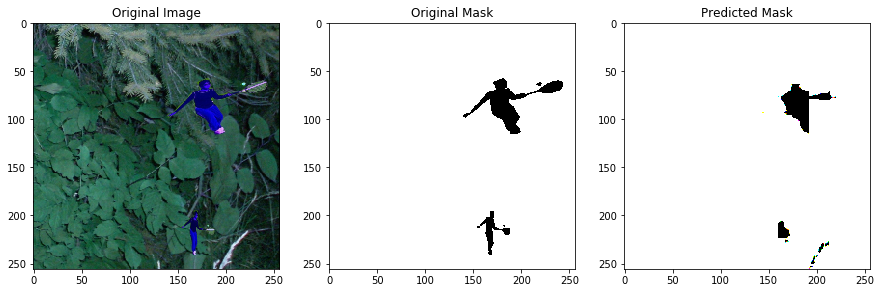

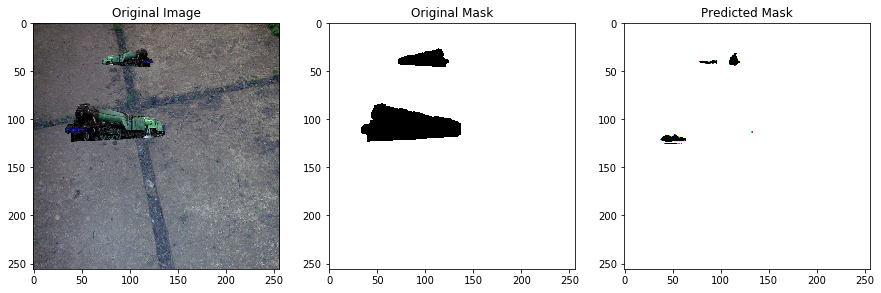

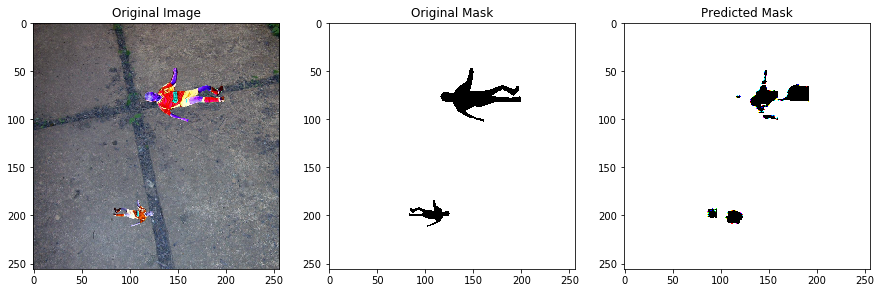

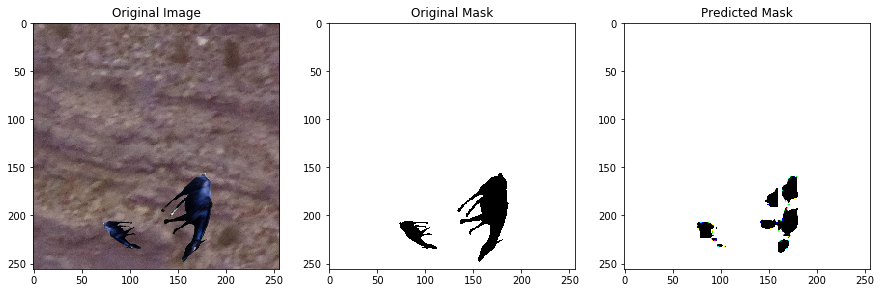

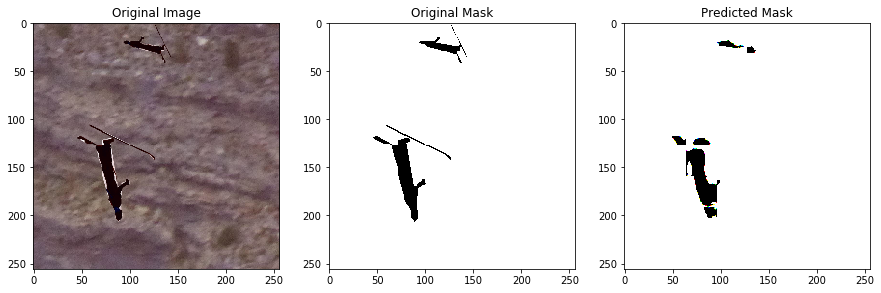

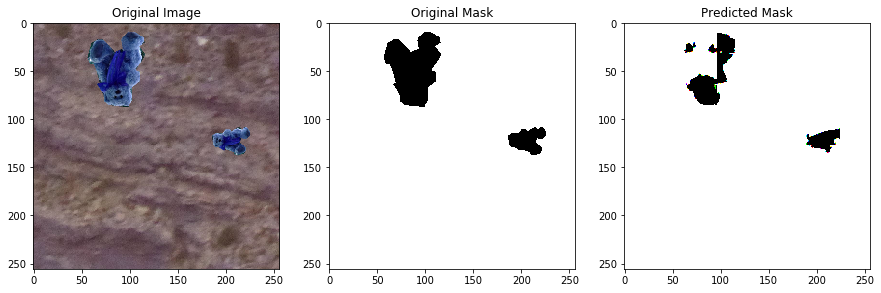

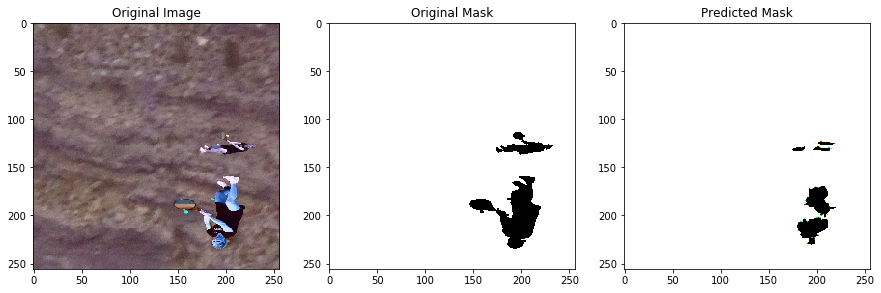

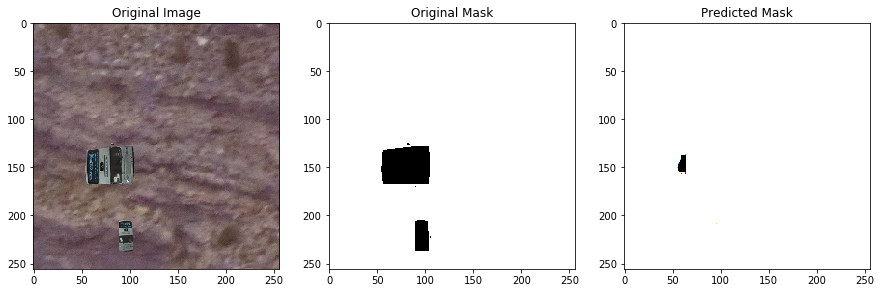

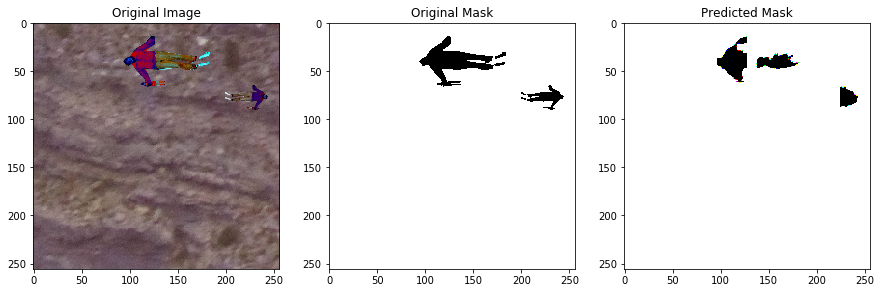

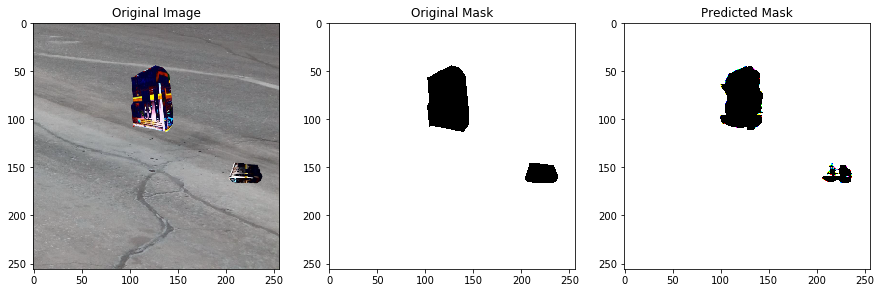

In [0]:
#Plot the sample output.
for i in range(1000,1010):
  plot_image(np.round(out[i*64:i*64+64]),y_train[i*64:i*64+64],x_train[i*64:i*64+64])

**Evaluate using IEEE dataset**

In [0]:
#Use the Fake Image repository alone for this.
from tqdm import tqdm
import os
import cv2
from cv2 import imread
from sklearn.feature_extraction import image
img_arr = []
mask_arr = []



file_names = set()
files = sorted(os.listdir('/content/dataset-dist/phase-01/training/fake'))

for i in range(len(files)):
  if(files[i].endswith('.png')):
    file_names.add(files[i].split('.')[0])
    
for i in file_names:
  #cv2.IMREAD_GRAYSCALE
  img = imread('/content/dataset-dist/phase-01/training/fake/'+str(i)+'.png')
  img = cv2.resize(img,(256,256))
  img_arr.append(img)
  #cv2.IMREAD_GRAYSCALE
  mask = imread('/content/dataset-dist/phase-01/training/fake/'+str(i)+'.mask.png')
  mask = cv2.resize(mask,(256,256))
  mask_arr.append(mask)

In [0]:
#split into patches.
from skimage.util import view_as_windows
from tqdm import tqdm

patch_arr = []
patch_label = []
patch_mask = []

for i in tqdm(range(len(mask_arr))):
  img_patches = view_as_windows(img_arr[i],(32,32,3),32)
  img_patches = np.squeeze(img_patches)
  img_patches = np.reshape(img_patches,(64,32,32,3))
  
  mask_patches = view_as_windows(np.round(mask_arr[i]/255),(32,32,3),32)
  mask_patches = np.squeeze(mask_patches)
  mask_patches = np.reshape(mask_patches,(64,32,32,3))

  for k in range(len(mask_patches)):
    patch_arr.append(img_patches[k])
    patch_mask.append(mask_patches[k])

100%|██████████| 450/450 [00:01<00:00, 367.47it/s]


**Generate Test Set**

In [0]:
import numpy as np
img_rows, img_cols = 32, 32
x_test = np.array(patch_arr).reshape(len(patch_arr), img_rows, img_cols,3)

x_test = x_test.astype('float32')
x_test /= 255
print('x_train shape:', x_test.shape)
print(x_test.shape[0], 'train samples')
input_shape = (img_rows, img_cols, 3)

x_train shape: (28800, 32, 32, 3)
28800 train samples


In [0]:
import numpy as np
img_rows, img_cols = 32, 32
y_test = np.array(patch_mask).reshape(len(patch_mask), img_rows, img_cols,3)

y_test = np.round(y_test)
#y_train /= 255
print('y_train shape:', y_test.shape)
print(y_test.shape[0], 'train samples')
input_shape = (img_rows, img_cols, 3)

y_train shape: (28800, 32, 32, 3)
28800 train samples


In [0]:
out = model.predict(x_test)

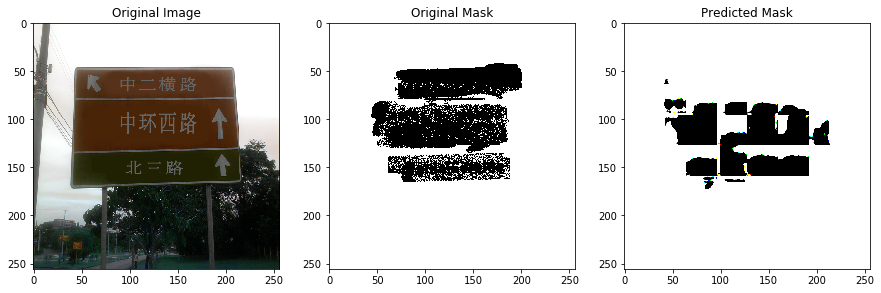

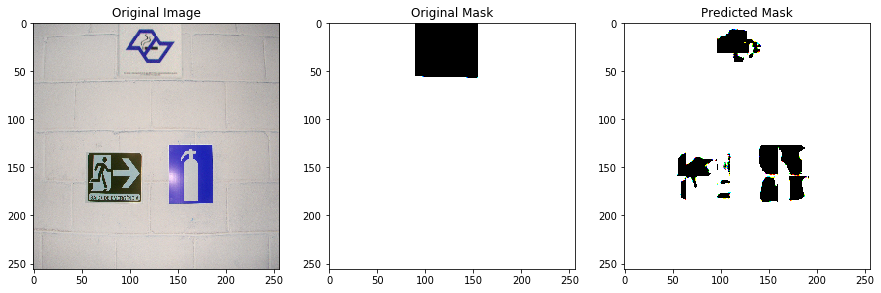

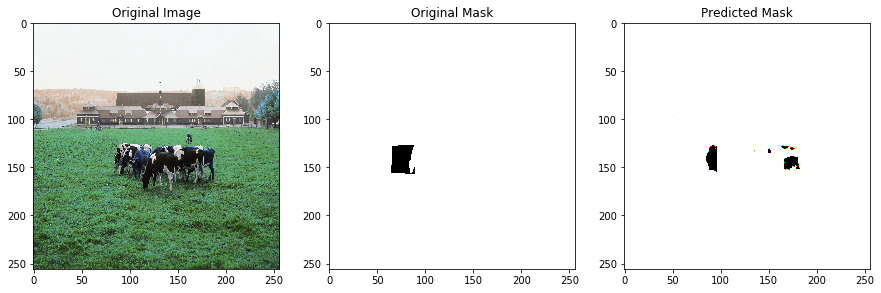

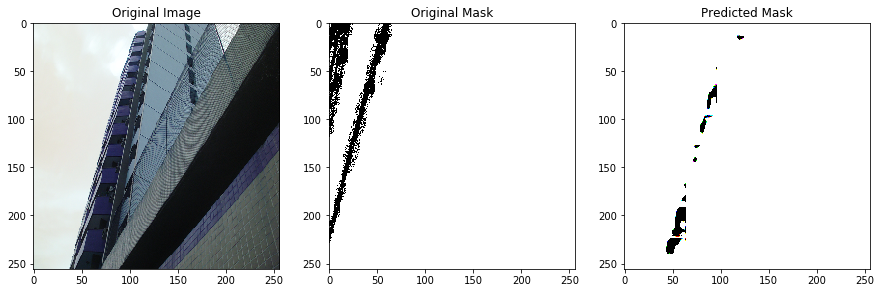

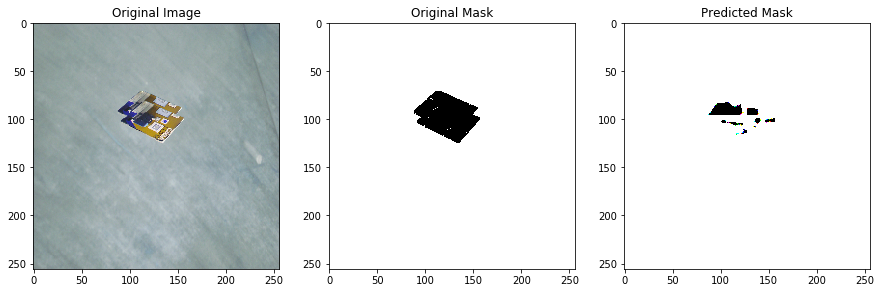

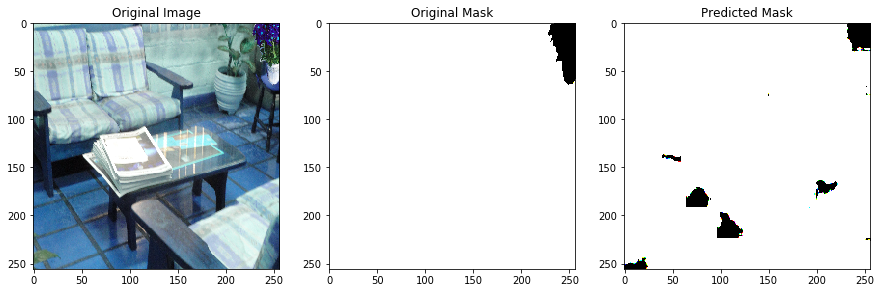

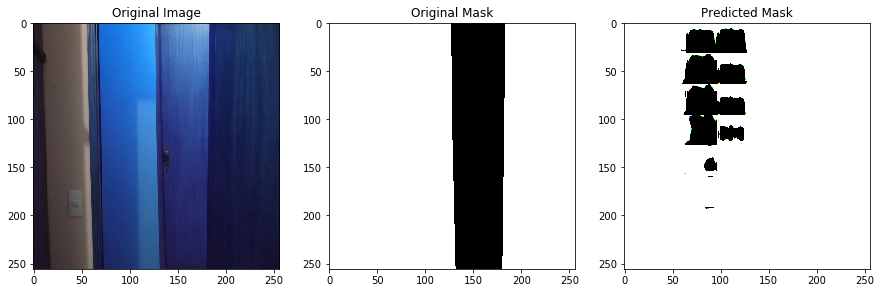

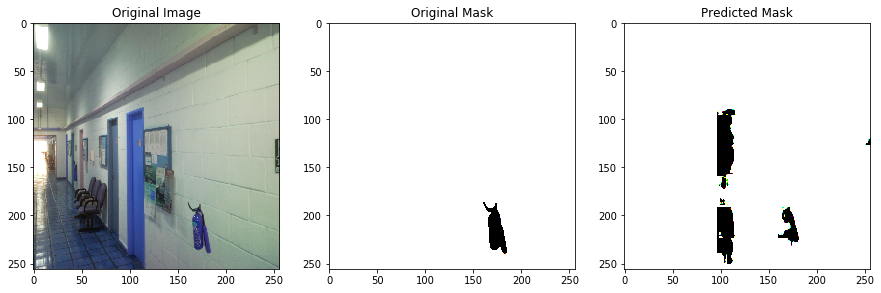

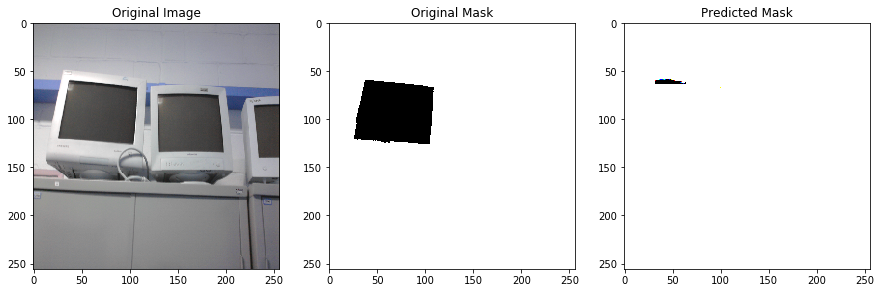

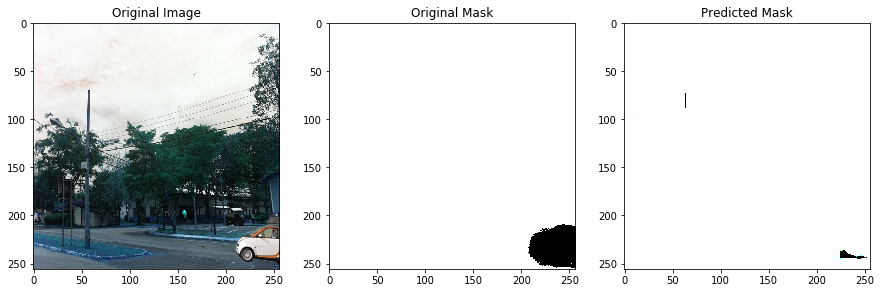

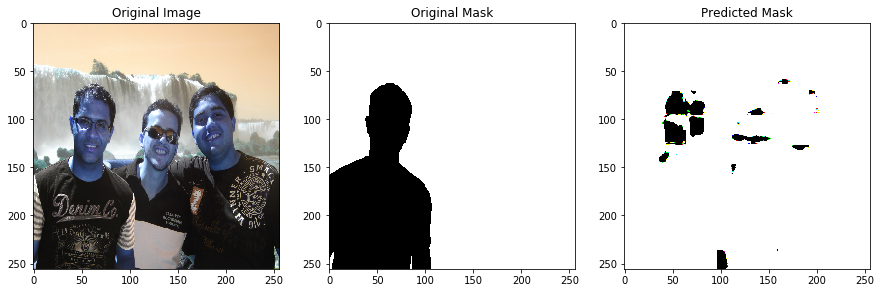

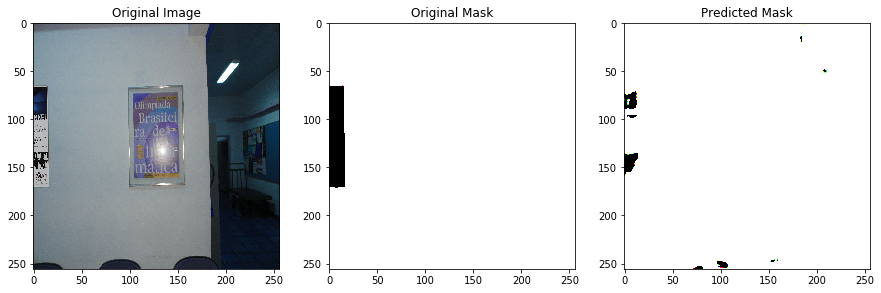

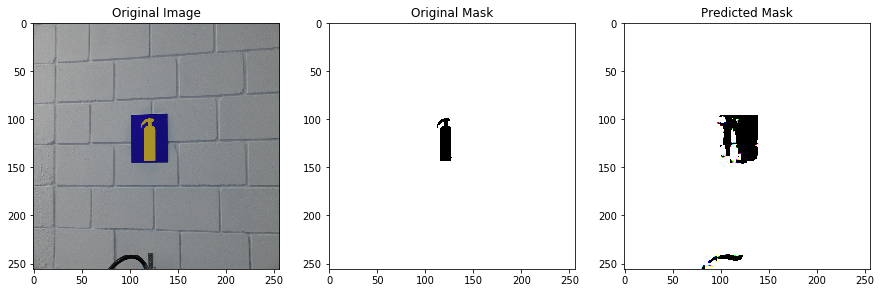

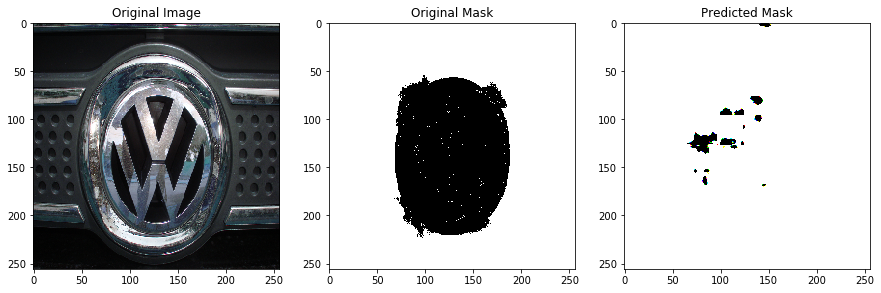

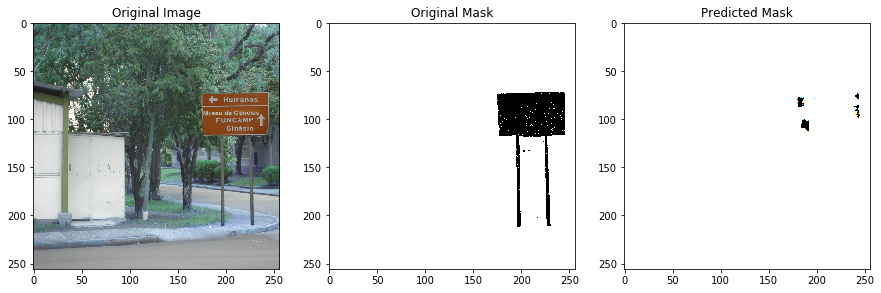

In [0]:
#Plot Sample Points
for i in range(15):
  plot_image(np.round(out[i*64:i*64+64]),y_test[i*64:i*64+64],x_test[i*64:i*64+64])

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Save the model
model.save("/content/drive/My Drive/final_loc_model.h5")

In [34]:
#Load the Saved Model
from keras.models import load_model
import tensorflow as tf
model = load_model('/content/drive/My Drive/final_loc_model.h5',custom_objects={'tf': tf})









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
import tarfile
tarf = tarfile.open("/content/NC2016_Test0601.tgz")
tarf.extractall()

In [0]:
import os
files = os.listdir('/content/NC2016_Test0601/probe')

In [36]:
len(files)

1124

In [37]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [0]:
from tqdm import tqdm
import os
import cv2
from cv2 import imread
from sklearn.feature_extraction import image

In [0]:
files = sorted(os.listdir('/content/NC2016_Test0601/probe/'))

img_arr = []

#for i in range(len(files)):
#  if(files[i].endswith('.png')):
#    file_names.add(files[i].split('.')[0])
    
for i in files:
  #cv2.IMREAD_GRAYSCALE
  img = imread('/content/NC2016_Test0601/probe/'+i)
  img = cv2.resize(img,(256,256))
  
  img_arr.append(img)
  #cv2.IMREAD_GRAYSCALE
  
  #mask = imread('/content/Bernard/Computer_Vision/spliced_copymove_NIST/masks/'+i.split('_rgb.png')[0]+'_mask.png')
  #mask = cv2.resize(mask,(256,256))
  #mask_arr.append(mask)

**Testing with NIST**

    This was given to me by AAIC.

In [50]:
#Generate the Image Patches.
from skimage.util import view_as_windows
from tqdm import tqdm

patch_arr = []

for i in tqdm(range(len(img_arr))):
  
  #img_patches = image.extract_patches_2d(img_arr[i], (96, 96),random_state=24)
  img_patches = view_as_windows(img_arr[i],(32,32,3),32)
  img_patches = np.squeeze(img_patches)
  img_patches = np.reshape(img_patches,(64,32,32,3))
  
  for k in range(len(img_patches)):
    patch_arr.append(img_patches[k])
    


100%|██████████| 1124/1124 [00:00<00:00, 5847.39it/s]

In [0]:
#This will restore Images from their patches
def get_img_from_patch(patch1_pred):
  a1 = np.concatenate((patch1_pred[0], patch1_pred[1], patch1_pred[2], patch1_pred[3], patch1_pred[4], patch1_pred[5], patch1_pred[6], patch1_pred[7]), axis=1)

  a2 = np.concatenate((patch1_pred[8], patch1_pred[9], patch1_pred[10], patch1_pred[11], patch1_pred[12], patch1_pred[13], patch1_pred[14], patch1_pred[15]), axis=1)

  a3 = np.concatenate((patch1_pred[16], patch1_pred[17], patch1_pred[18], patch1_pred[19], patch1_pred[20], patch1_pred[21], patch1_pred[22], patch1_pred[23]), axis=1)

  a4 = np.concatenate((patch1_pred[24], patch1_pred[25], patch1_pred[26], patch1_pred[27], patch1_pred[28], patch1_pred[29], patch1_pred[30], patch1_pred[31]), axis=1)

  a5 = np.concatenate((patch1_pred[32], patch1_pred[33], patch1_pred[34], patch1_pred[35], patch1_pred[36], patch1_pred[37], patch1_pred[38], patch1_pred[39]), axis=1)

  a6 = np.concatenate((patch1_pred[40], patch1_pred[41], patch1_pred[42], patch1_pred[43], patch1_pred[44], patch1_pred[45], patch1_pred[46], patch1_pred[47]), axis=1)

  a7 = np.concatenate((patch1_pred[48], patch1_pred[49], patch1_pred[50], patch1_pred[51], patch1_pred[52], patch1_pred[53], patch1_pred[54], patch1_pred[55]), axis=1)

  a8 = np.concatenate((patch1_pred[56], patch1_pred[57], patch1_pred[58], patch1_pred[59], patch1_pred[60], patch1_pred[61], patch1_pred[62], patch1_pred[63]), axis=1)

  dd = np.concatenate((a1, a2,a3,a4,a5,a6,a7,a8), axis=0)
  return dd

In [59]:
import numpy as np
img_rows, img_cols = 32, 32
x_test = np.array(patch_arr).reshape(len(patch_arr), img_rows, img_cols,3)

x_test = x_test.astype('float32')
x_test /= 255
print('x_train shape:', x_test.shape)
print(x_test.shape[0], 'train samples')
input_shape = (img_rows, img_cols, 3)

x_train shape: (71936, 32, 32, 3)
71936 train samples


In [0]:
out = model.predict(x_test)

In [0]:
def plot_image(pred,test_x): 
  f = plt.figure(figsize=(15,15))
  f.add_subplot(1,3, 2)
  plt.imshow(get_img_from_patch(pred))
  plt.title('Predicted Mask')
  #f.add_subplot(1,3, 2)
  #plt.imshow(get_img_from_patch(test_y))
  #plt.title('Original Mask')
  f.add_subplot(1,3,1)
  plt.imshow(get_img_from_patch(test_x))
  plt.title('Original Image')
  plt.show(block=False)

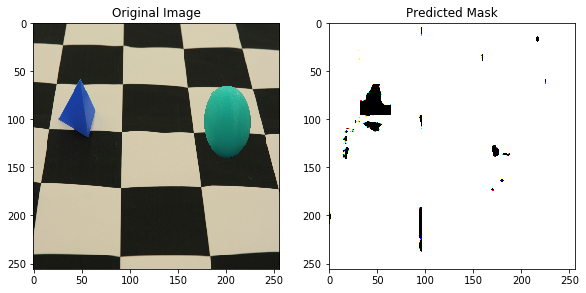

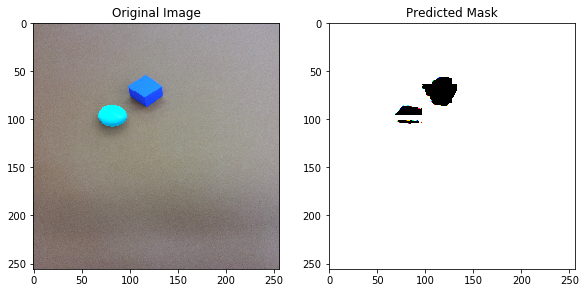

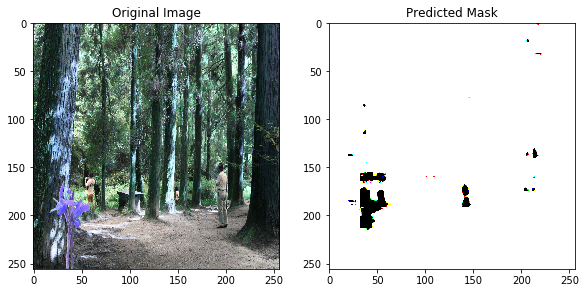

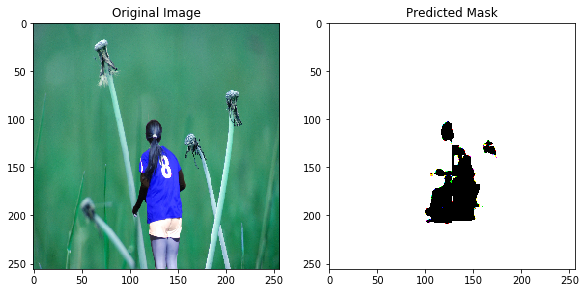

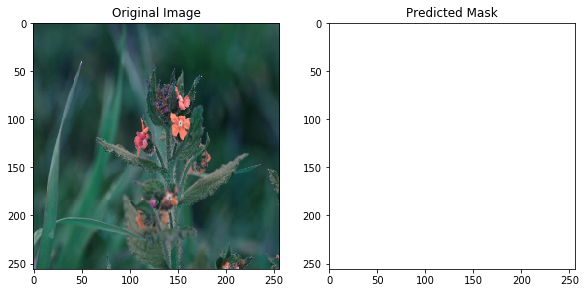

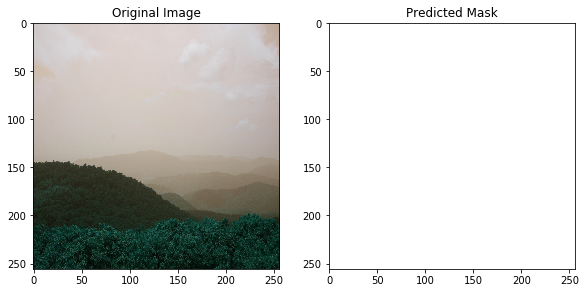

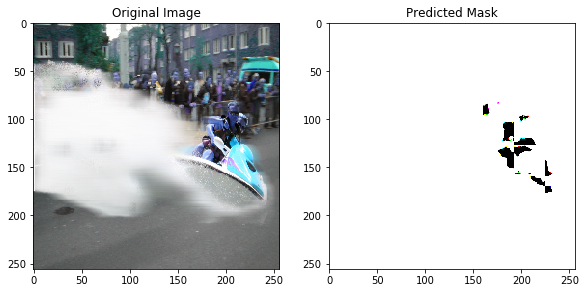

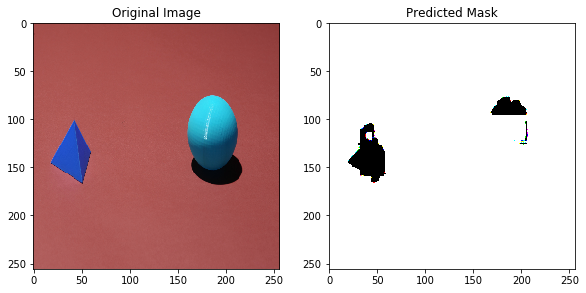

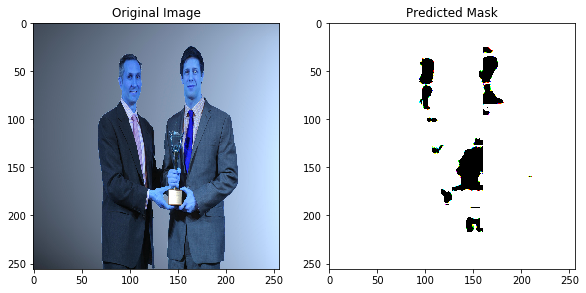

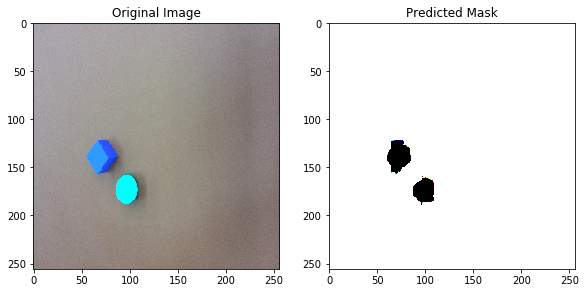

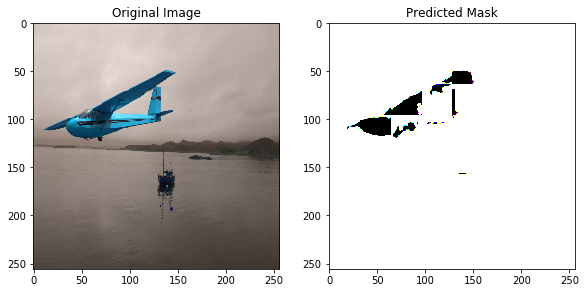

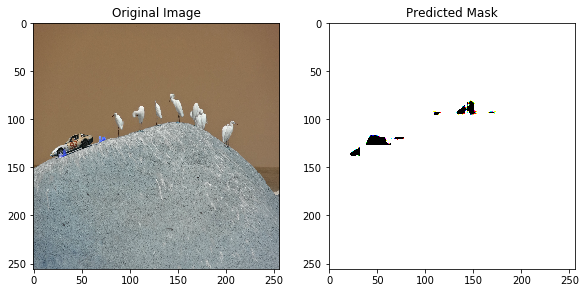

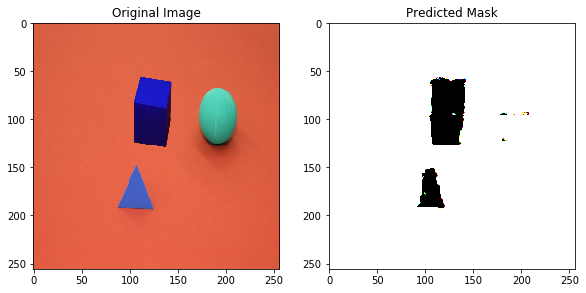

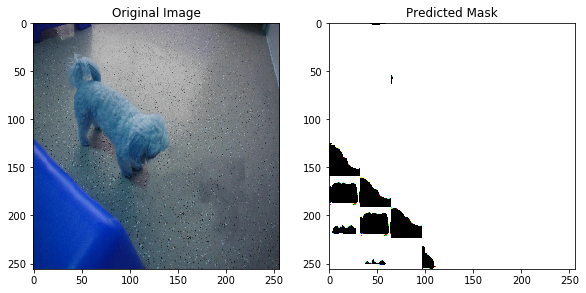

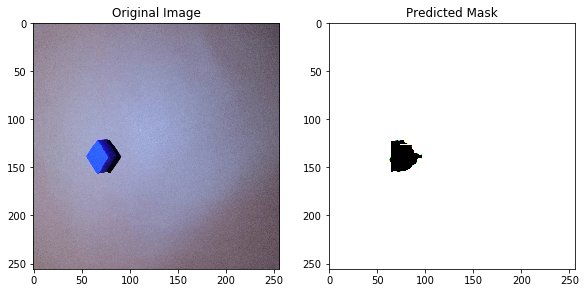

In [76]:
for i in range(15):
  plot_image(np.round(out[i*64:i*64+64]),x_test[i*64:i*64+64])

## Observations And Results : 

- For Part1 : 
    
    - > The Model Does a Good job in classifying the Patches on both training and testing Set of Synthetic Dataset.
    
    - > For IEEE Dataset, For the Image classification task, it does a decent job
    
    - > The main reason for that is cos for IEEE Dataset, they have used Complicated techniques to make image forgery which is much more than Simple Copy move and Splicing which is the reason why model struggles.
    
- Part 2 :
    
    - > For patch generatation, the model does a really good job in both the Synthetic as well as the NIST Dataset.
    
    - > For IEEE Dataset it still does an Okay job. The main reason for models not working well for IEEE is because of above mentioned reasons.
    
    - > The results of both Part1 and Par2 could be improved if more images are considered. However due to memory constraints I could only use around 4k images.